In [1]:
import pandas as pd
import joblib
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.svm import SVC

# Data preprocessing for our models

##### We still have some data preprocessing to do for our ML models. Here, we are focusing on datatypes and feature scaling to ensure the model can interpret the data much better.


##### I have opted to make 0/1 data columns (where 1= true) boolean for memory efficiency and interpretability by the model. 

In [20]:
Final_df = pd.read_csv('Final_diabetes.csv')
Final_df.head()

,id,Age,Gender,height(cm),weight(kg),BMI(kg/m2),SBP(mmHg),DBP(mmHg),FPG(mmol/L),Cholesterol(mmol/L),...,LDL(mmol/L),ALT(U/L),AST(U/L),BUN(mmol/L),CCR(umol/L),FPG_Final,Censor_Diabetes_Diagnosed,Smoking_status,Drinking_status,Family_history_diabetes
0,1,43,2,166.4,53.5,19.3,96.0,57.0,4.99,5.13,...,2.768231,10.0,24.084889,3.080000,50.3,4.97,0,3.0,3.0,1
1,11,59,1,165.0,63.0,23.1,136.0,73.0,5.70,4.50,...,2.800000,15.0,24.084889,5.760000,62.6,5.50,0,3.0,3.0,0
2,34,31,1,161.5,58.5,22.4,104.0,74.0,5.78,4.48,...,2.768231,23.6,24.084889,6.820000,96.5,5.10,0,3.0,3.0,0
3,53,25,2,157.0,50.0,20.3,102.0,60.0,5.70,4.05,...,2.768231,13.2,24.084889,4.657683,51.2,4.85,0,3.0,3.0,0
4,59,66,1,156.0,60.5,24.9,133.0,78.0,5.80,4.67,...,2.320000,23.8,28.900000,6.600000,89.8,6.31,0,1.0,3.0,0


In [3]:
Final_df['Gender'] = Final_df['Gender'].map({1: True, 2: False})
Final_df['Censor_Diabetes_Diagnosed'] = Final_df['Censor_Diabetes_Diagnosed'].astype(bool)
Final_df[' Family_history_diabetes'] = Final_df[' Family_history_diabetes'].astype(bool)
Final_df['Smoking_status'] = Final_df['Smoking_status'].astype('int64')
Final_df['Drinking_status'] = Final_df['Drinking_status'].astype('int64')

In [4]:
Final_df.dtypes

id                             int64
Age                            int64
Gender                          bool
height(cm)                   float64
weight(kg)                   float64
BMI(kg/m2)                   float64
SBP(mmHg)                    float64
DBP(mmHg)                    float64
FPG(mmol/L)                  float64
Cholesterol(mmol/L)          float64
Triglyceride(mmol/L)         float64
HDL(mmol/L)                  float64
LDL(mmol/L)                  float64
ALT(U/L)                     float64
AST(U/L)                     float64
BUN(mmol/L)                  float64
CCR(umol/L)                  float64
FPG_Final                    float64
Censor_Diabetes_Diagnosed       bool
Smoking_status                 int64
Drinking_status                int64
 Family_history_diabetes        bool
dtype: object

##### We do not need to one-hot encode anything here, since all data types are bool, int or float. If you recall, our 2 columns 'smoking_status' and 'drinking_status' have already been formatted via label encoding by the creator of the dataset- since there is an order from 1-3 denoting smoking and drinking intensity.This label encoding is also highly suitable for our tree-based models we are planning to use. 

In [5]:
# Lets strip the whitespace with our family_history_diabetes column! 
Final_df.columns = Final_df.columns.str.strip()

# Now lets split the data into training, test and validation

In [6]:
x= Final_df.drop(['Censor_Diabetes_Diagnosed','id'], axis=1)
y= Final_df['Censor_Diabetes_Diagnosed']

##### We are dropping our 'target' value and the 'id' column as Censor_Diabetes_Diagnosed is our target value and the 'id' does not function as a predictor

In [7]:
x_train, x_rem, y_train, y_rem = train_test_split(x, y, train_size=0.6, random_state=42)

In [8]:
print("Training set shape: x_train:", x_train.shape, "y_train:", y_train.shape)

Training set shape: x_train: (36138, 20) y_train: (36138,)


##### Now splitting the remaining data into test and validation datasets.
##### Validation to tune and validate the model parameters. I am using a seperate dataset as the model may be overexposed to the training data when hyperparamater tuning and thus would benefit from a seperate dataset

In [9]:
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, test_size=0.5, random_state=42)

In [10]:
print("Validation set shape: x_val:", x_val.shape, "y_val:", y_val.shape)
print("Testing set shape: x_test:", x_test.shape, "y_test:", y_test.shape)

Validation set shape: x_val: (12046, 20) y_val: (12046,)
Testing set shape: x_test: (12046, 20) y_test: (12046,)


#### Scaling the numerical data 

We have a wide range of numerical data, and whilst the medical data from blood test values may be closely linked, other values may not be. We need to ensure all features included all contribute equally to the model, which should improve their performance. We can see below there are features with much larger ranges than others e.g., smoking status is from 1-3 but we have height(cm) in a larger range. Scaling this data will help out distance-based algorithm we hope to employ (Support Vector Machines (SVM). Whilst scaling data is unecessary for tree-based models, since we are also employing an SVM, we need to scale the data. 

In [11]:
numerical_cols = Final_df.select_dtypes(include=['float64', 'int64']).drop(columns=['id'], errors='ignore').columns
Final_df[numerical_cols].head()

,Age,height(cm),weight(kg),BMI(kg/m2),SBP(mmHg),DBP(mmHg),FPG(mmol/L),Cholesterol(mmol/L),Triglyceride(mmol/L),HDL(mmol/L),LDL(mmol/L),ALT(U/L),AST(U/L),BUN(mmol/L),CCR(umol/L),FPG_Final,Smoking_status,Drinking_status
0,43,166.4,53.5,19.3,96.0,57.0,4.99,5.13,0.78,1.372051,2.768231,10.0,24.084889,3.080000,50.3,4.97,3,3
1,59,165.0,63.0,23.1,136.0,73.0,5.70,4.50,0.75,1.530000,2.800000,15.0,24.084889,5.760000,62.6,5.50,3,3
2,31,161.5,58.5,22.4,104.0,74.0,5.78,4.48,0.78,1.372051,2.768231,23.6,24.084889,6.820000,96.5,5.10,3,3
3,25,157.0,50.0,20.3,102.0,60.0,5.70,4.05,0.43,1.372051,2.768231,13.2,24.084889,4.657683,51.2,4.85,3,3
4,66,156.0,60.5,24.9,133.0,78.0,5.80,4.67,1.22,1.372051,2.320000,23.8,28.900000,6.600000,89.8,6.31,1,3


##### We need to exclude the smoking and drinking status from the scaler as these are ordinal variables. Scaling these will lead to potential misinterpretation by our models.

##### We have decided to use a Robust scaler from scikit-learn as there is alot of outliers as seen in our data preprocessing (see box plots)- thus we should aim to minimise this. 

In [12]:
numerical_cols = numerical_cols.drop(['Smoking_status', 'Drinking_status']) # Dropping columns: The code removes the columns 'satisfaction_score' and 'number_of_referrals' from the numerical_cols list.

scaler = RobustScaler()

In [13]:
x_train[numerical_cols] = scaler.fit_transform(x_train[numerical_cols]) # Scaling the 3 datasets we have:
x_test[numerical_cols] = scaler.fit_transform(x_test[numerical_cols])
x_val[numerical_cols]= scaler.fit_transform(x_val[numerical_cols])

In [14]:
y_train.value_counts()
# defining how wide a scope of diabetes doagnosis data we have... seem to have very little for true

Censor_Diabetes_Diagnosed
False    35405
True       733
Name: count, dtype: int64

# Now that the data is ready for modelling, we will use 2 models: A SVM and a Tree-based model: Random Forest

Why are we using these two? 
For medical diagnosis prediction, it is often never just one feature that only links to the disease- thus we should utilise all the features available to help build a better image of the predictability of type 2 diabetes- These 2 models are great at looking itno all features e..g, highly dimensional data. Furthermore given the numerous outliers in the dataset, we must use tree-based models and SVM to help reduce extreme values. Though, the drawbacks here are there is a higher chance of overfitting- these will have to be mitigated.


# Random Forest

#### Why are we beginning with a RANDOM FOREST model?:

The motivation to experiment with Random Forest lies in its ability to reduce overfitting and increase predictive performance by averaging the results of many decision trees. This ensemble method enhances stability and accuracy, making it less sensitive to the variations and noise in the dataset.

 The complexity of assessing multiple trees can make it less interpretable compared to a single decision tree, but its strengths in handling complex, high-dimensional data and reducing overfitting make it a powerful tool for predicting diabetes within our dataset

In [21]:
rf = RandomForestClassifier(n_estimators=25, max_depth= 3, min_samples_split= 5, random_state=42)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_split=5, n_estimators=25,
                       random_state=42)

In [22]:
# Model Evaluation
y_pred = rf.predict(x_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.2f}")

Accuracy: 0.99


##### The accuracy seems to be extremly high. Lets check with cross validation

In [23]:
# Check the accuracy on the training data and test data
train_accuracy = rf.score(x_train, y_train)
test_accuracy = rf.score(x_test, y_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


Training Accuracy: 0.9869942996291992
Test Accuracy: 0.9883778847750291


##### Given that both training and test accuracy is similar- it can suggest the model is generalizing well to the test data and isnt severly overfitting

In [24]:

cv_scores = cross_val_score(rf, x_train, y_train, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-validation accuracy: 0.9859 ± 0.0019


##### cross validation results:

The result of cross-validation accuracy indicates that the Random Forest model is consistently performing well across different data splits, and the performance is relatively stable (with a small standard deviation of 0.0014). This means that the model is not overfitting and should generalize well to unseen data.

The deviation shows the model's performance is consistent across different data splits. 

However, the accuracy is quite high (possibly due to the small datset we have). Lets fine tune the hyperparameters to see if it can prevent overfitting. 

We will find the ideal hyperparameters for the random forest model through random grid search. Given that grid search is computationally expensive and requires heavy processing, I have decide to use a random grid search, which will be quicker and require less processing power. The below range of values for our parameters hve been researched within the context of random forest models- we are using the average range. We are applying this to our validation data so that we can see the best combination of hyperparameters to unseen data. The model may memorise patterns seen in training data- before we even train the model- thus a seperate validation dataset needs to be used.

In [ ]:

# Defining the hyperparameter grid here. we are using the validation set for this!
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=10,
    random_state=42,
    n_jobs=4
)

# applying these parameters to our validation data and testing its performance:
random_search_rf.fit(x_val, y_val)
best_rf = random_search_rf.best_estimator_

# Best parameters and accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Model Accuracy:", round(random_search.best_score_, 3))

In [ ]:
Tuned_y_pred = best_rf.predict(x_test)
y_pred_best_prob_rf = best_rf.predict_proba(x_test)[:, 1]
print("Accuracy of the model: {}%".format(accuracy(y_test, y_pred_best_rf)))

In [ ]:
cv_scores = cross_val_score(best_rf, x_val, y_val, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

##### Interestingly, the accuracy of the hyperparameter tuned random forest model has worser accuracy. This may be from overfitting or too much complexity in the model. The slight drop from cross-validation accuracy (99.61%) to test accuracy (96.71%) is not uncommon and can happen due to factors like overfitting, data splitting, or variance in data difficulty.

##### However, the standard deviation from cross validation is very small, indicating the model is stable. 

In [ ]:
cm = confusion_matrix(y_val, Tuned_y_pred) # creating confusion matrix against the validation data values and the predited ones in our new model

# Print confusion matrix
print("Confusion Matrix:")

# Visualize confusion matrix with a heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='pink', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Analysis of the confusion matrix:
Here we have 11650 instances of the model correctly predicting the negative class (e.g., patients without diabetes), and 2 instances of correctly predicting the positive class. 

This shows that the model is struggling to predict the positve class (i.e., predicting diabetes) This may be a fault of the data- where in there is a high number of negatives versus true positives- thus the model may be heavily biased towards predicting the negative class. The high prediction thus may be towards predicting negatives alone. It seems we have highly imbalanced classes.


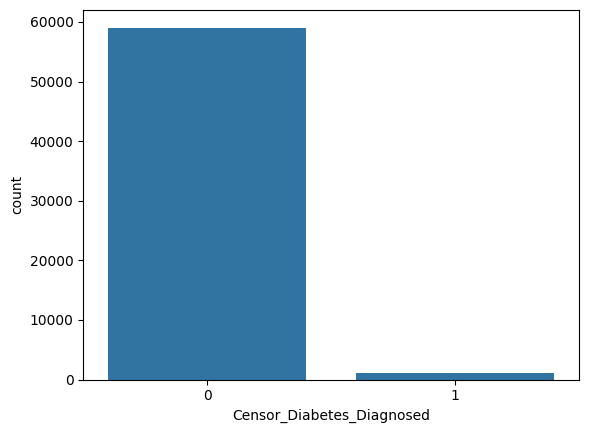

In [27]:
# Below is graphical demonstration of just how unbalanced these classes are:

sns.countplot(data= Final_df, x='Censor_Diabetes_Diagnosed')
plt.show()

### Adapting the model: Lets use the random forest classifier to balance the weights and test this again. This will give more weight to the positive class e.g., the correct diagnosis of diabetes. 

In [ ]:

Weighted_rf = RandomForestClassifier(class_weight='balanced', random_state=42, 
                                 n_estimators=best_rf.n_estimators, 
                                 max_depth=best_rf.max_depth, 
                                 min_samples_split=best_rf.min_samples_split)# using ideal hyperparameters + balancing the weight of the classes of diabetes


Weighted_rf.fit(x_val, y_val)



In [ ]:
Weighted_y_pred = Weighted_rf.predict(x_test)
best_rf = Weighted_rf.predict(x_test)
print("Accuracy of the model: {}%".format(accuracy(y_test, best_rf)))


In [ ]:
cm = confusion_matrix(y_val, Weighted_y_pred) # creating confusion matrix against the validation data values and the predicted ones in our new model

# Print confusion matrix
print("Confusion Matrix:")

# Visualize confusion matrix with a heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='pink', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##### Perhaps the F1 score will highlight a better prediction. F1 score keeps the balance between precision and recall and improves the score only if the classifier identifies more of a certain class correctly.

In [ ]:

f1= f1_score(y_val, Weighted_y_pred)
print(f"f1 score is {f1:.4f}")

In [4]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## This has not worked!

Calculating an F1 score seems to be a better evaluator of performance of a binary classification model. Our f1 score is even worse- closer to 0 than 1 showing that this model is extremly poor at predicitng diabetes. Lets try a new technique, using a BalancedBaggingClassifier to see if this improves the model- we will use the 'best hyperparameters' from our grid search as beginning hyperparameters: Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}

In [ ]:
bbc = BalancedBaggingClassifier(
    estimator= RandomForestClassifier(max_depth=10, min_samples_split=10),
    random_state=42, 
    n_estimators= 100, 
    sampling_strategy = 'auto', # to balance the classes
    replacement=False
)



In [35]:
bbc.fit(x_train, y_train)

y_predict=bbc.predict(x_test)

In [36]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.99      1.00      0.99     11831
        True       0.97      0.36      0.52       215

    accuracy                           0.99     12046
   macro avg       0.98      0.68      0.76     12046
weighted avg       0.99      0.99      0.99     12046



## Analysing the classification report 
Based on this classification report, the precision is high at 0.97 i.e., the model accurately predicts the individuals with diabetes (True in this binary data type). Out of all the non-diabetes patients, 99% predicted were correct.

With recall however, the results differ. we get a result of 100% for correctly diagnosing the patient without diabetes. However, for diabetes, this is 36%. The F1 score is shockingly low at 0.52- which is less than ideal.  Random forest models may struggle with recall in highly imbalanced datasets such as this.

# Lets try an SVM with class weighting. 

#### Why are we moving to an SVM model instead of our random forest one?

After much research, it appears an SVM may work more effectively and use less memory resources than a random forest model, given its prowess with small datasets and imbalanced classes. SVM's have also commonly been applied to disease prediction models. The following reasons highlight how the SVM might outshine the random forest model in this case, despite their similarities:

- SVMs can handle complex non-linear relationships- as stated previously, we are dealing with low correlations between diabetes diagnosis and the indicators- thus highlighting there is no clear linear relationship. Such is the norm with medical data and diagnoses.
  
- Our dataset is highly dimensional. There are roughly 20+ indicator features for diabetes diagnosis, all relevant for our usecase for the model.

- Our medical data includes alot of outliers. SVMs are accustomed to focus on the support vectors and thus less susceptible to outlier influence.

- finally, the small sample size we have would better suit an SVM.


##### We will use class weights to balance out the data, giving much more weight to our diabetes positive diagnosis


In [15]:

svm = SVC(kernel= 'linear', class_weight={0: 1, 1: 3}, probability=True, random_state=42)
svm.fit(x_train, y_train)
# note I am using a random kernel choice, based on research, linear seemed most fitting for class weights

y_pred_svm = svm.predict(x_test)


In [16]:
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.99      1.00     11831
        True       0.75      0.84      0.79       215

    accuracy                           0.99     12046
   macro avg       0.87      0.92      0.89     12046
weighted avg       0.99      0.99      0.99     12046



##### Here we have balanced the weights of each class using a common weight balance of 1:3, weighing the 'True' i.e., prediction of diabetes as higher. 
We are essentially making the model become more cautious about predicting positives, reducing false positives and making precision higher. 

Precision- weighted class balancing is useful in this scenario, where a false positive of diabetes diagnosis is highly undesired. We have a lot of negatives over positives on our data. Here the tradeoff between precision and recall is not awful. Lets hyperparameter tune with our validation dataset and see if we can improve these scores!


In [24]:
svm2 = SVC(probability=True, random_state=42)

param_dist = {
    'C': [0.1, 1, 10, 100],  
    'kernel': ['rbf', 'linear'],  
    'gamma': ['scale', 'auto', 0.001, 0.1],  
    'class_weight': ['balanced', {0: 1, 1: 3}, {0: 1, 1: 5}],  # Class balancing options
    'degree': [3, 4, 5],  
    'coef0': [0, 0.1, 0.5] 
}
random_search_CV = RandomizedSearchCV(
    estimator=svm2,
    param_distributions=param_dist,
    n_iter=10,  # Number of random configurations to test
    cv=5,  # Number of cross-validation folds
    scoring='f1',  
    n_jobs= 4,  
    random_state=42
)


random_search_CV.fit(x_val, y_val)

# Get the best parameters and the best model
best_params = random_search_CV.best_params_
best_model = random_search_CV.best_estimator_


print("Best hyperparameters:", best_params)

Best hyperparameters: {'kernel': 'linear', 'gamma': 0.001, 'degree': 5, 'coef0': 0, 'class_weight': {0: 1, 1: 3}, 'C': 1}


In [25]:
# predictions on the test set
y_pred_svm2 = best_model.predict(x_test)

In [26]:
print("Classification Report:\n", classification_report(y_test, y_pred_svm2))

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     11831
        True       0.83      0.80      0.81       215

    accuracy                           0.99     12046
   macro avg       0.91      0.90      0.90     12046
weighted avg       0.99      0.99      0.99     12046



##### What we see here is a greatly improved model. 
The F1 score has increased greatly to 0.81, highlighting a great tradeoff and maximisation of both precision and recall. We focused on the f1 score here as it is a much more comprehensive evaluation metric. This is a large step up from our random forest model, using balanced weights were we saw the F1 score as 0.52. It is important that this score is as high as possible, as we want to ensure correct diagnosis between the 2 result classes as accurately as possible. 

Whilst the recall value for true diagnosis of diabetes has dropped from 0.84-0.80 after hyperparameters being tuned, the precision has increased. This is key for our model, as precision will measure how often it correctly predicted the positive instance of diabetes- whch is the main aim of the model. 


# Conclusions

Our final model best fitting to this dataset and use case is our SVM 'best_model'. This was a weight balanced model, with a final F1-score of 0.81 for the correct diagnosis of diabetes, and 1.00 for the negative case. This greatly outshined our random forest model- which we experimented on twice with tuning hyperparameters, and using balanced weights for the classes. 

Whilst we could have fitted a weighted class identifier to the random forest model, it was important for the assignment context to explore other model types and see their ability to correctly diagnose. 

### Limitations
It is important to note the limitations of our random search parameters. Given the lengthy time it takes for the function to run and the low processing power of the local computer, fewer parameters and 'n_jobs' was set to 4 for the CPU core. This seemed to work best given the time taken to random search for the model. Ideally, more random configurations would be used, and perhaps a grid search, looking at all combinations would more accurately define the best hyperparameters. 

### Application of the model on real data?

Due to the nature of the model, and how complex diagnosis detection is, I do not believe this model is fit for application in a hospital setting as it is right now. However, with more data following the same context of this data (e.g., wide age range, wide range of values etc) and more testing by experts, I believe a model such as this could be placed within the healthcare environment. For example, since majority of features are indeed blood test values, patient data could be extracted from a simple blood test, and questinnaire on their BMI, smoking/drinking status and family history, then fed into the model to determine their diagnosis of type 2 diabetes, saving time within the NHS for analysis of results, whilst also providing a quicker answer to the patient. Diabetes type 2 is manageable and even reversible, so speed of diagnosis is crucial for this application.